In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx

In [0]:
df = pd.read_csv('imdb_dataset_visualise.csv')
# df = pd.read_csv('imdb_dataset_filtered.csv')[:1000]

In [0]:
print(len(df))
display(df[:5])

81


,titleId,title,directorId,director,year,titleType,isAdult,runtimeMins,genres,avgRating,numVotes,region,language,types,isOriginalTitle
0,tt0038813,La otra,nm0310449,Roberto Gavaldón,1946,movie,0,98,\N,7.3,225,NO,\N,imdbDisplay,0
1,tt0039323,La diosa arrodillada,nm0310449,Roberto Gavaldón,1947,movie,0,107,\N,7.1,198,XWW,en,\N,0
2,tt0042434,En la palma de tu mano,nm0310449,Roberto Gavaldón,1951,movie,0,90,\N,7.5,182,XWG,\N,\N,0
3,tt0054042,Macario,nm0310449,Roberto Gavaldón,1960,movie,0,91,\N,8.3,2287,\N,\N,original,1
4,tt0055945,Días de otoño,nm0310449,Roberto Gavaldón,1963,movie,0,95,\N,7.1,142,US,\N,\N,0


In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
from random import choice

def circular_layout(G):

    center = np.zeros(2)
    
    components = nx.connected_component_subgraphs(G)

    if len(G) == 0:
        pos = {}
    elif len(G) == 1:
        pos = {nx.utils.arbitrary_element(G): center}
    else:
        pos = {}
        for comp in components:
            radius = len(comp) * 2 / len(G)
            center -= max(0.15, radius * 0.8)
            theta = np.linspace(0, 1, len(comp) + 1)[:-1] * 2 * np.pi
            theta = theta.astype(np.float32)
            cur_pos = np.column_stack([np.cos(theta) * radius,
                                       np.sin(theta) * radius]) + center
            pos.update(dict(zip(comp.nodes, cur_pos)))
            center -= max(0.15, radius * 0.8)

    return pos


def square_layout(G):

    center = np.zeros(2)
    
    components = nx.connected_component_subgraphs(G)

    if len(G) == 0:
        pos = {}
    elif len(G) == 1:
        pos = {nx.utils.arbitrary_element(G): center}
    else:
        pos = {}
        for comp in components:
            radius = len(comp) * 2 / len(G)
            center -= max(0.2, radius * 1.1)
            xs = np.concatenate((np.linspace(-radius, radius, (len(comp) + 3) // 4 + 1)[:-1],
                                 np.zeros((len(comp) + 2) // 4) + radius,
                                 -np.linspace(-radius, radius, (len(comp) + 1) // 4 + 1)[:-1],
                                 np.zeros(len(comp) // 4) - radius))
            ys = np.concatenate((np.zeros((len(comp) + 3) // 4) + radius,
                                 -np.linspace(-radius, radius, (len(comp) + 2) // 4 + 1)[:-1],
                                 np.zeros((len(comp) + 1) // 4) - radius,
                                 np.linspace(-radius, radius, len(comp) // 4 + 1)[:-1]))
            cur_pos = np.column_stack([xs, ys]) + center
            pos.update(dict(zip(comp, cur_pos)))
            center -= max(0.2, radius * 1.1)

    return pos

def distances_layout(G, distance=1, diameter=False):

    center = np.zeros(2)
    
    components = nx.connected_component_subgraphs(G)

    if len(G) == 0:
        pos = {}
        path_labels = {}
    elif len(G) == 1:
        pos = {nx.utils.arbitrary_element(G): center}
        path_labels = {nx.utils.arbitrary_element(G): '0'}
    else:
        pos = {}
        path_labels = {}
        for comp in components:
            if diameter:
                ecc = nx.eccentricity(comp)
                p = dict(nx.single_source_shortest_path_length(comp, max(ecc, key=ecc.get)))
            else:
                p = dict(nx.single_source_shortest_path_length(comp, choice(list(comp.nodes))))
            Distances = {}
            for node in p:
                if p[node] not in Distances:
                    Distances[p[node]] = [node]
                else:
                    Distances[p[node]].append(node)
            max_elems = 0
            for dist in Distances:
                num_elems = len(Distances[dist])
                if max_elems < num_elems:
                    max_elems = num_elems
            center[1] -= max(3, np.sqrt(max_elems))
            for dist in Distances:
                num_elems = len(Distances[dist])
                ys = np.linspace(-np.sqrt(num_elems), np.sqrt(num_elems), num_elems + 2)[1:-1]
                xs = np.repeat(dist * distance, num_elems)
                cur_pos = np.column_stack([xs, ys]) + center
                cur_labels = np.repeat(dist, num_elems).astype(str)
                pos.update(dict(zip(Distances[dist], cur_pos)))
                path_labels.update(dict(zip(Distances[dist], cur_labels)))
            center[1] -= max(3, np.sqrt(max_elems))

    return pos, path_labels

def distances_circular_layout(G, distance=1, diameter=False):

    center = np.zeros(2)
    
    components = nx.connected_component_subgraphs(G)

    if len(G) == 0:
        pos = {}
        path_labels = {}
    elif len(G) == 1:
        pos = {nx.utils.arbitrary_element(G): center}
        path_labels = {nx.utils.arbitrary_element(G): '0'}
    else:
        pos = {}
        path_labels = {}
        for comp in components:
            if diameter:
                ecc = nx.eccentricity(comp)
                p = dict(nx.single_source_shortest_path_length(comp, max(ecc, key=ecc.get)))
            else:
                p = dict(nx.single_source_shortest_path_length(comp, choice(list(comp.nodes))))
            Distances = {}
            for node in p:
                if p[node] not in Distances:
                    Distances[p[node]] = [node]
                else:
                    Distances[p[node]].append(node)
            max_dist = max(Distances)
            center[1] -= max(2, max_dist) * 2
            for dist in Distances:
                num_elems = len(Distances[dist])
                theta = np.linspace(0, 1, num_elems + 1)[:-1] * 2 * np.pi
                cur_pos = np.column_stack([np.cos(theta) * 2 * dist * distance,
                                           np.sin(theta) * 2 * dist * distance]) + center
                cur_labels = np.repeat(dist, num_elems).astype(str)
                pos.update(dict(zip(Distances[dist], cur_pos)))
                path_labels.update(dict(zip(Distances[dist], cur_labels)))
            center[1] -= max(2, max_dist) * 2

    return pos, path_labels

In [0]:
def names_cut(name):
    words = name.split()
    if len(words) > 2:
        return ' '.join(words[:2]) + "..."
    else:
        return name

Titles + Directors:

In [0]:
m = {}
d = {}
for index, row in df.iterrows():
    m[row['titleId']] = json.loads(row[['title', 'directorId', 'year', 'avgRating']].to_json())
    d[row['directorId']] = json.loads(row[['director']].to_json())

graph = nx.Graph()
Sizes = []
NodeColor = []
Names = {}
for key, value in m.items():
    Names[key] = names_cut(value['title'])
    Sizes.append(value['avgRating'] ** 5 / 60)
    NodeColor.append('orange')
    graph.add_node(key, node_type='title', title = value['title'], directorId = value['directorId'], year=value['year'], rating=value['avgRating'])
for key, value in d.items():
    Names[key] = names_cut(value['director'])
    Sizes.append(400)
    NodeColor.append('purple')
    graph.add_node(key, node_type='director', name = value['director'])

for m_key, m_value in m.items():
    for d_key, d_value in d.items():
        if m_value['directorId'] == d_key:
            graph.add_edge(m_key, d_key)

In [0]:
pos, path_labels = distances_layout(graph, diameter=True)

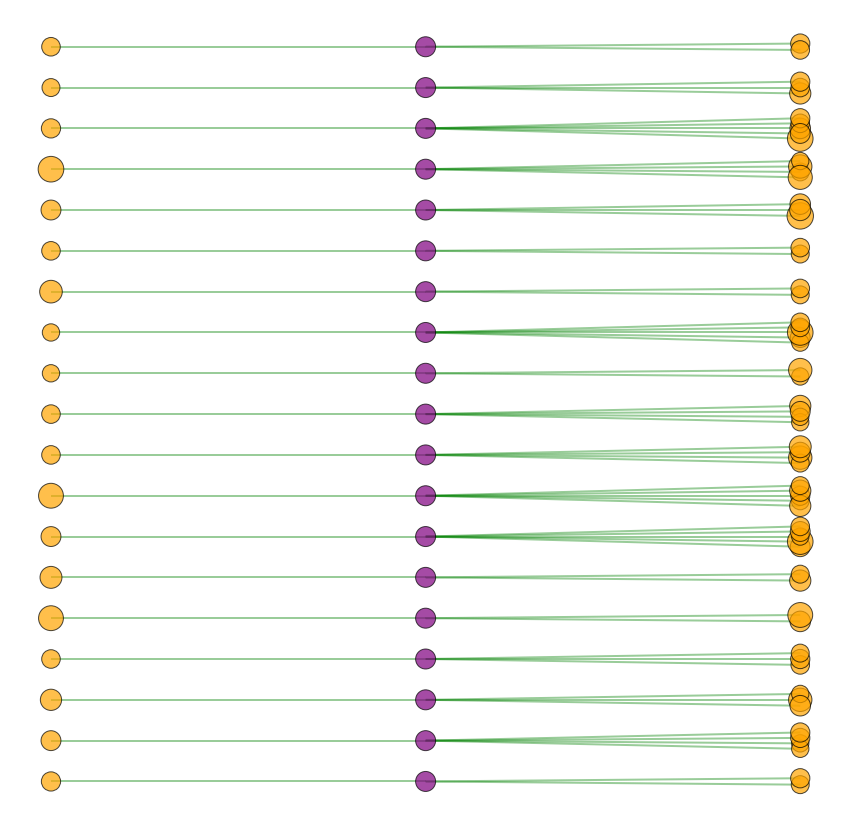

In [0]:
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color=NodeColor,
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color='green',
                       alpha=0.4)

plt.axis('off')
plt.show()

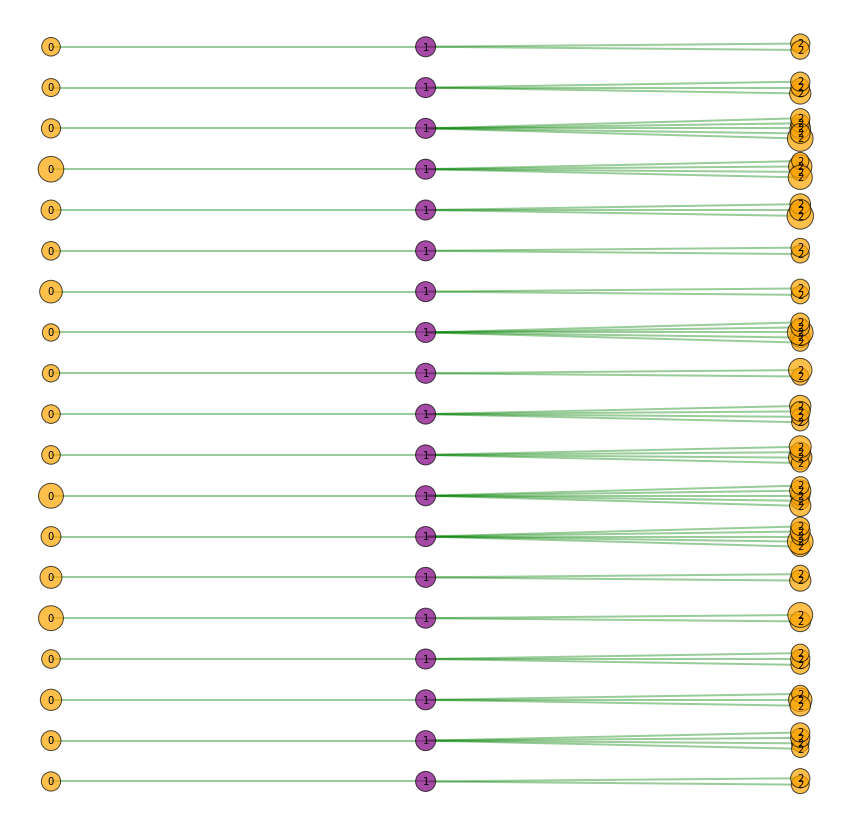

In [0]:
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color=NodeColor,
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color='green',
                       alpha=0.4)

nx.draw_networkx_labels(G=graph,
                        pos=pos,
                        labels=path_labels,
                        font_size=10)

plt.axis('off')
plt.show()

In [0]:
pos, path_labels = distances_circular_layout(graph, diameter=True)

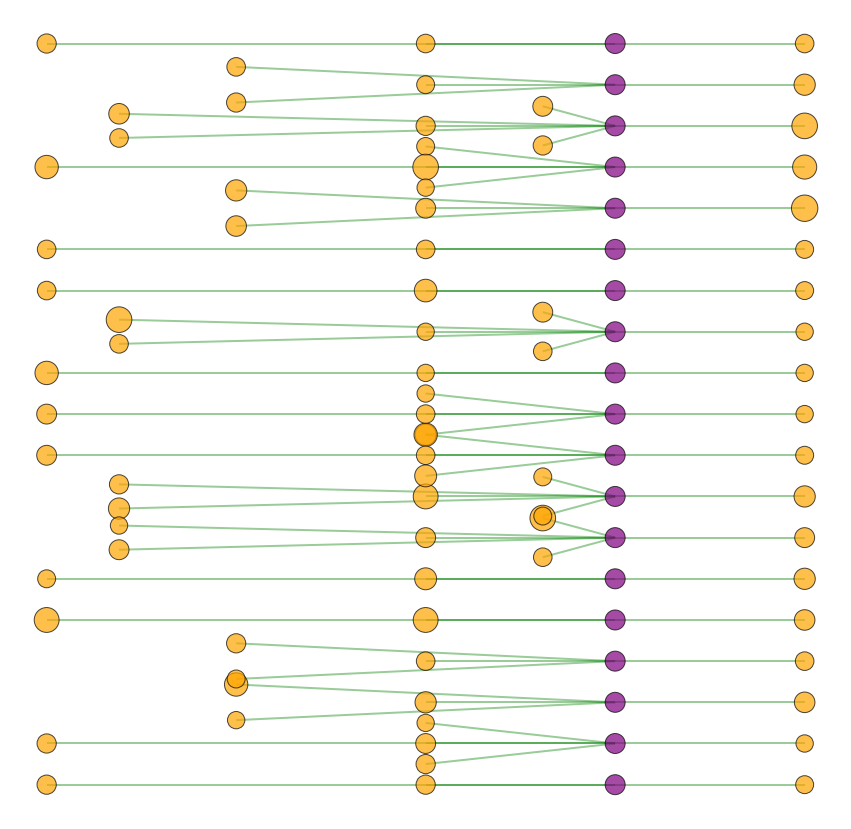

In [0]:
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color=NodeColor,
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color='green',
                       alpha=0.4)

plt.axis('off')
plt.show()

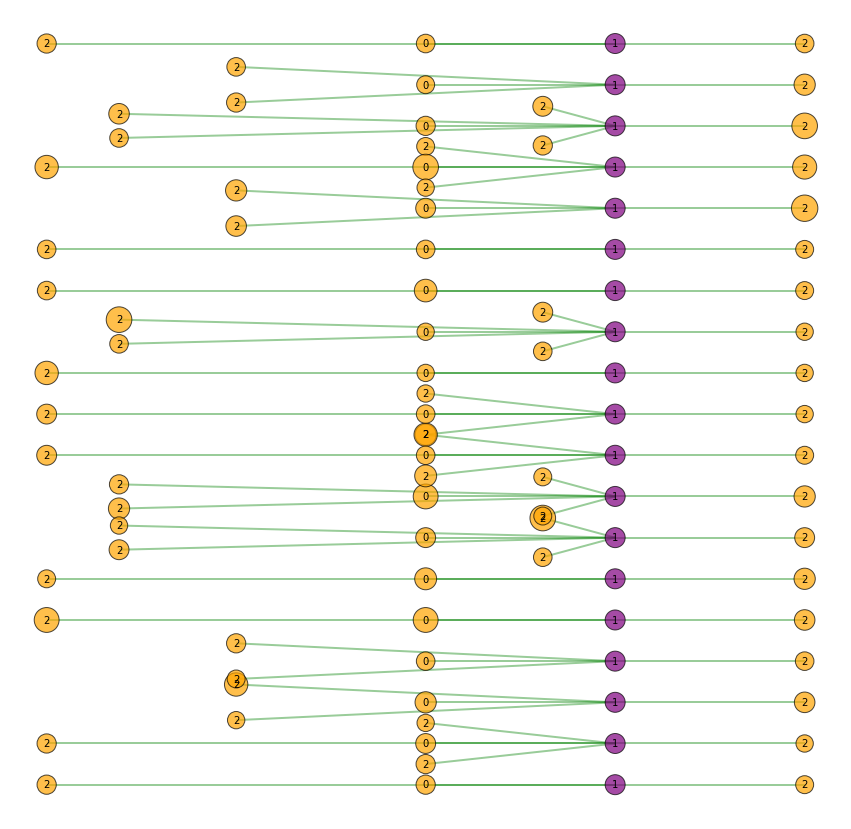

In [0]:
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color=NodeColor,
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color='green',
                       alpha=0.4)

nx.draw_networkx_labels(G=graph,
                        pos=pos,
                        labels=path_labels,
                        font_size=10)

plt.axis('off')
plt.show()

Titles:

In [0]:
d = {}
for index, row in df.iterrows():
    d[row['titleId']] = json.loads(row[['title', 'directorId', 'year', 'avgRating']].to_json())

In [0]:
graph = nx.Graph()
Sizes = []
Titles = {}
for key, value in d.items():
    Titles[key] = names_cut(value['title'])
    Sizes.append(value['avgRating'] ** 5 / 60)
    graph.add_node(key, title = value['title'], directorId = value['directorId'], year=value['year'], rating=value['avgRating'])

for key, group in df.groupby('directorId'):
    for i, row_i in group.iterrows():
        for j, row_j in group.iterrows():
            if i != j:
                graph.add_edge(row_i['titleId'], row_j['titleId'], color='green')

In [0]:
pos, path_labels = distances_layout(graph)

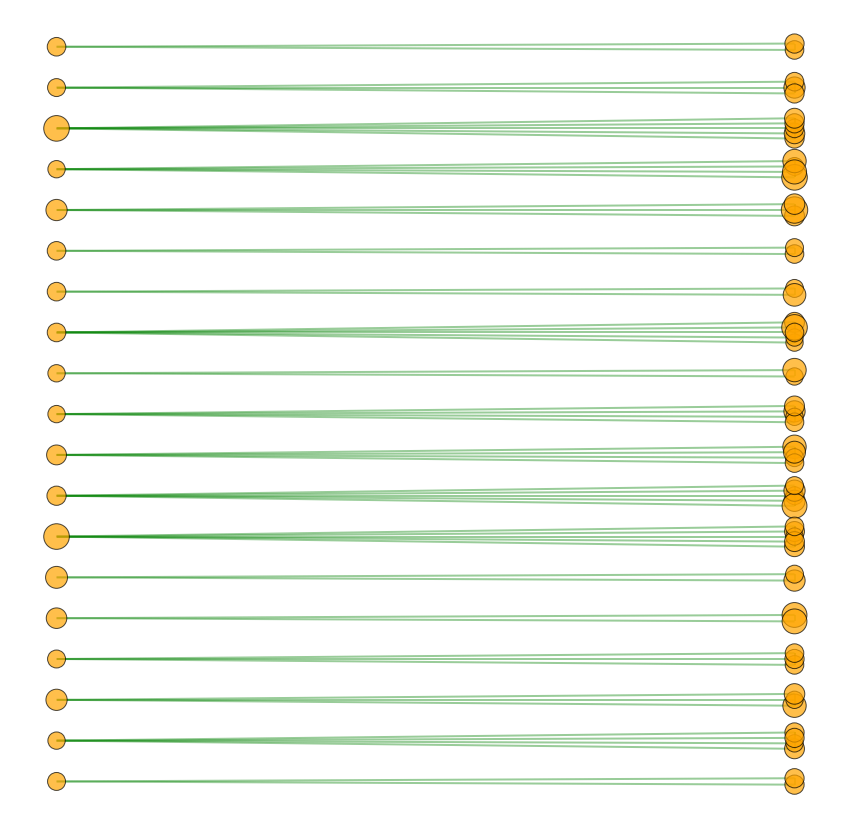

In [0]:
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color='orange',
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color='green',
                       alpha=0.4)

plt.axis('off')
plt.show()

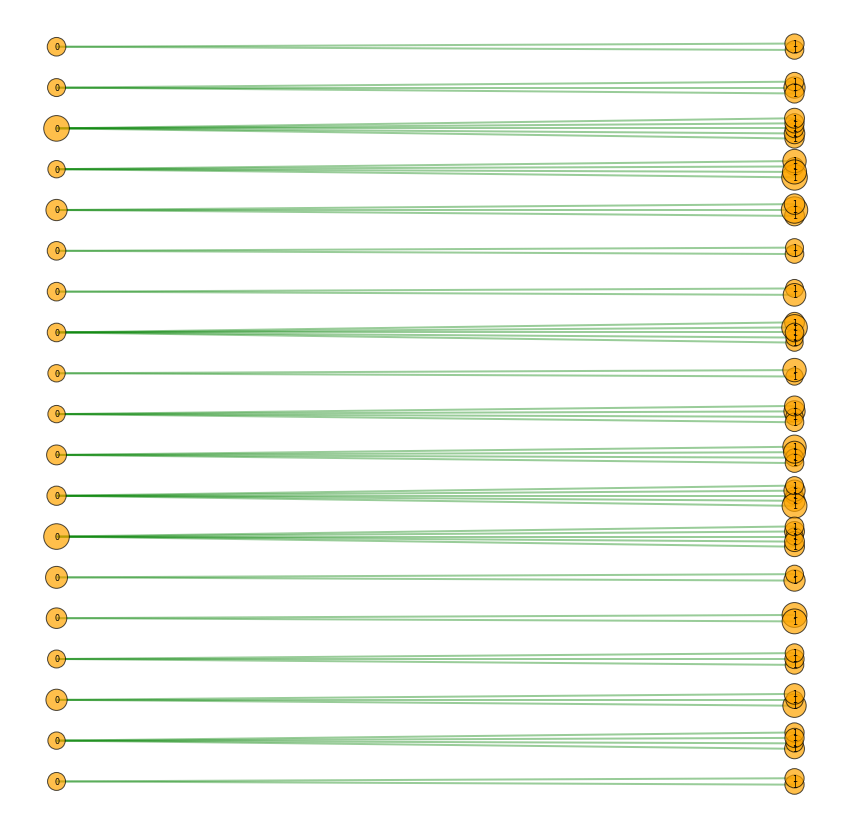

In [0]:
# only titles
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color='orange',
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color='green',
                       alpha=0.4)

nx.draw_networkx_labels(G=graph,
                        pos=pos,
                        labels=path_labels,
                        font_size=8)

plt.axis('off')
plt.show()

In [0]:
pos, path_labels = distances_circular_layout(graph)

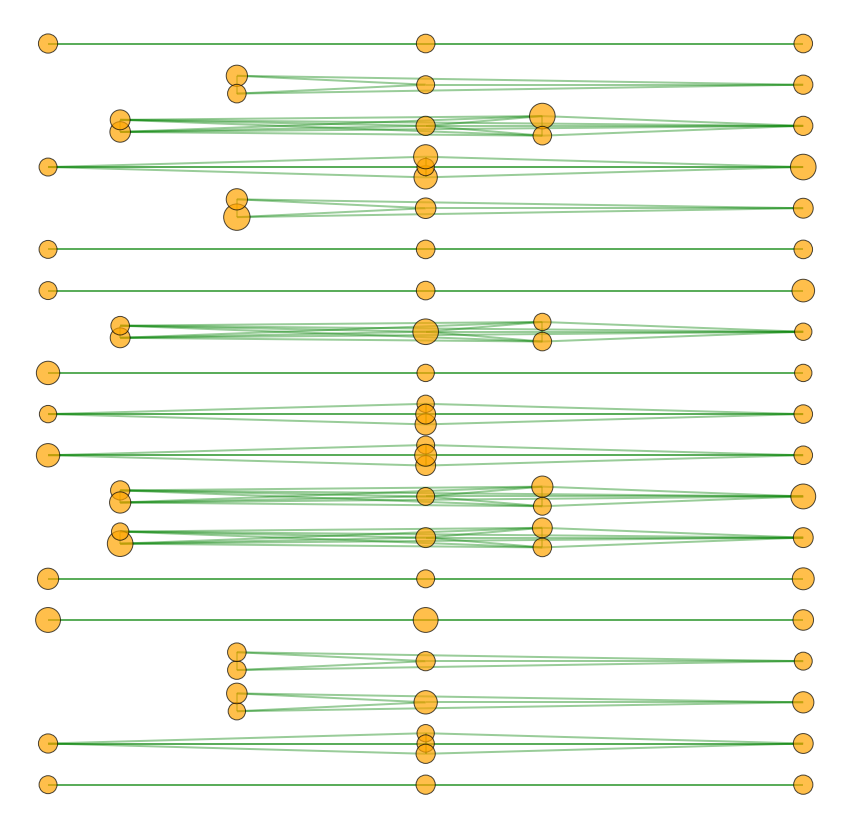

In [0]:
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color='orange',
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color='green',
                       alpha=0.4)

plt.axis('off')
plt.show()

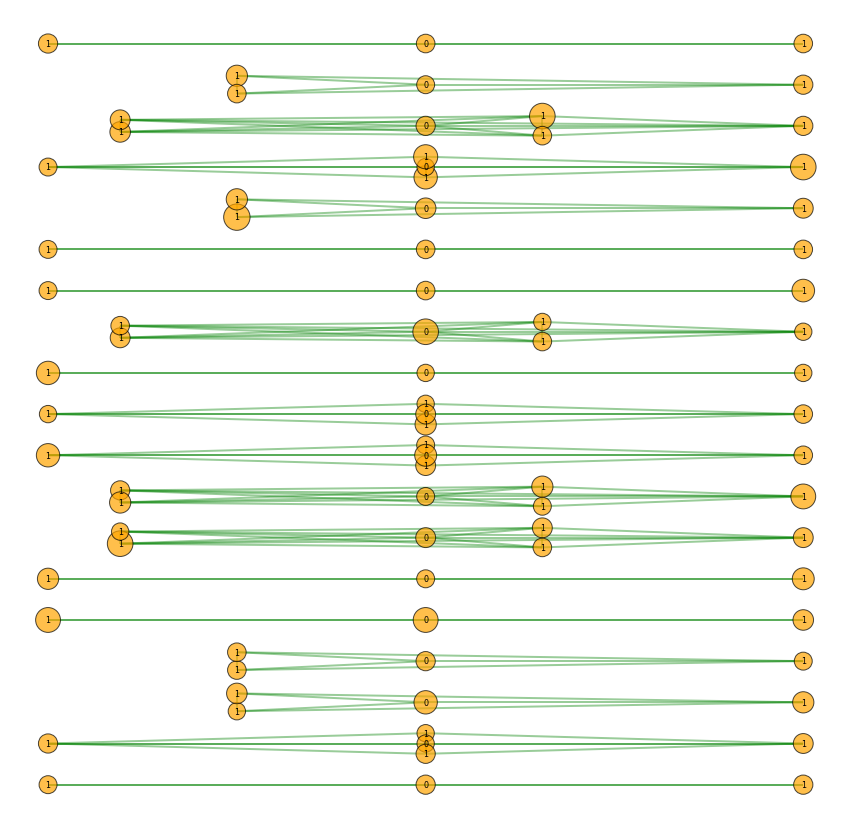

In [0]:
# only titles
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color='orange',
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color='green',
                       alpha=0.4)

nx.draw_networkx_labels(G=graph,
                        pos=pos,
                        labels=path_labels,
                        font_size=8)

plt.axis('off')
plt.show()

In [0]:
for key, group in df.groupby('year'):
    for i, row_i in group.iterrows():
        for j, row_j in group.iterrows():
            if i != j:
                graph.add_edge(row_i['titleId'], row_j['titleId'], color='purple')

In [0]:
EdgeColor = []
for edge in graph.edges:
    u, v = tuple(edge)
    EdgeColor.append(graph.get_edge_data(u, v)['color'])

In [0]:
pos, path_labels = distances_layout(graph, diameter=True)

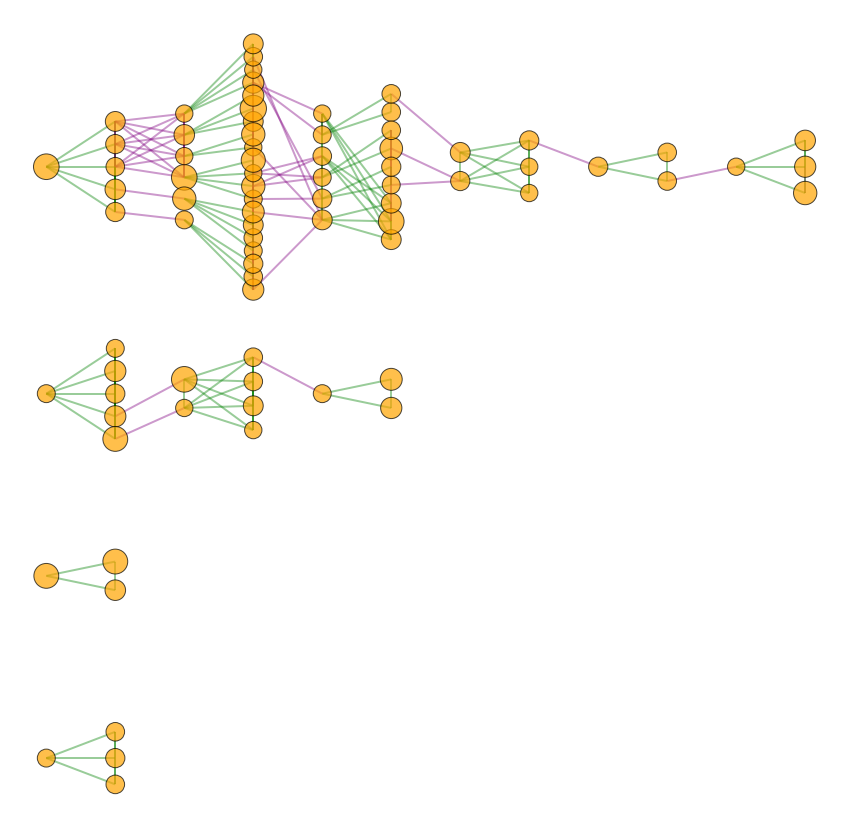

In [0]:
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color='orange',
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color=EdgeColor,
                       alpha=0.4)

plt.axis('off')
plt.show()

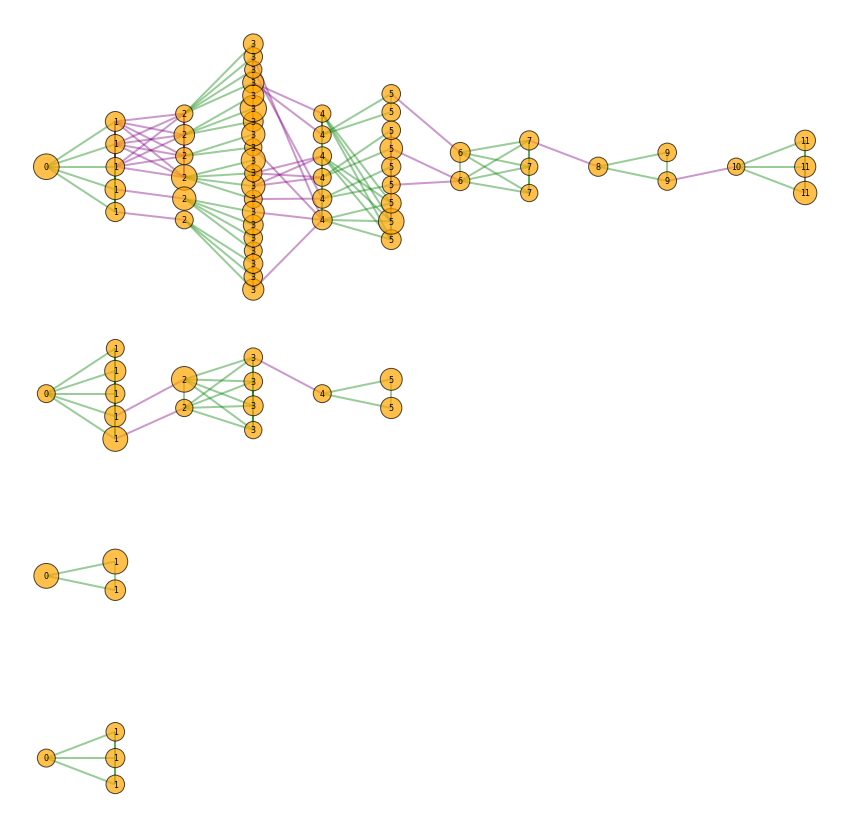

In [0]:
# only titles
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color='orange',
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color=EdgeColor,
                       alpha=0.4)

nx.draw_networkx_labels(G=graph,
                        pos=pos,
                        labels=path_labels,
                        font_size=8)

plt.axis('off')
plt.show()

In [0]:
pos, path_labels = distances_circular_layout(graph, diameter=True)

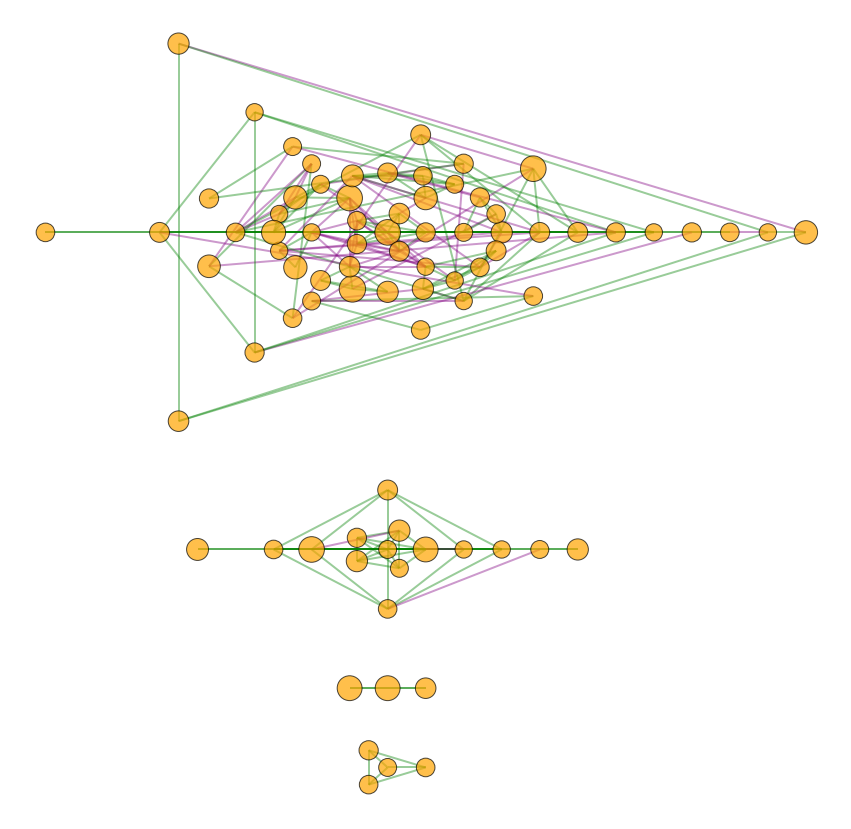

In [0]:
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color='orange',
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color=EdgeColor,
                       alpha=0.4)

plt.axis('off')
plt.show()

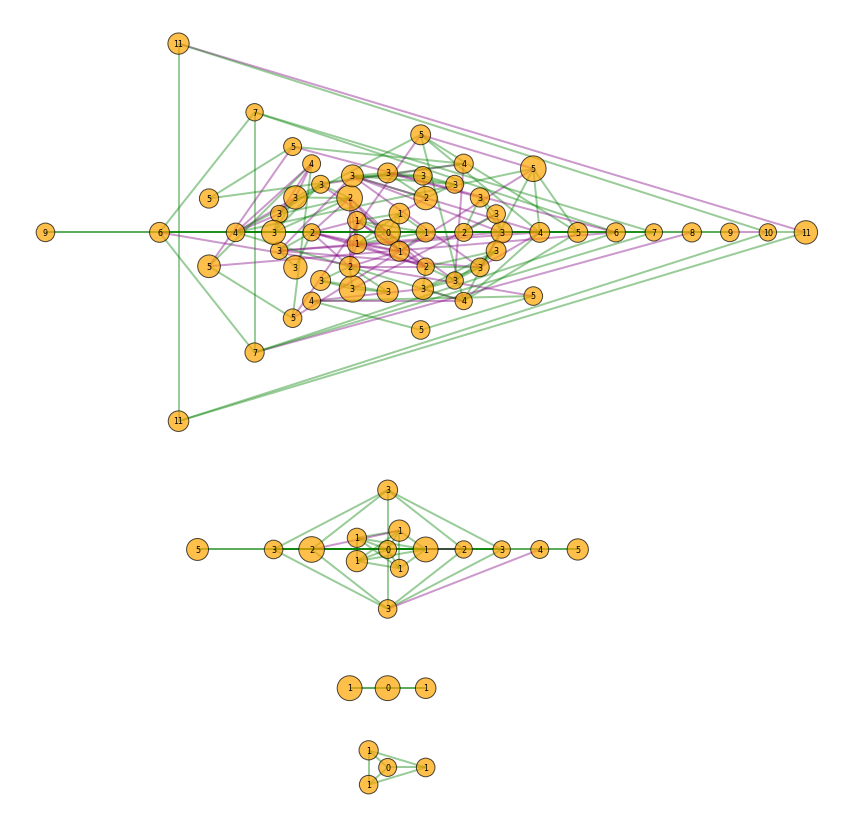

In [0]:
# only titles
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       node_size=Sizes,
                       node_color='orange',
                       node_shape='o',
                       alpha=0.7,
                       edgecolors='black')

nx.draw_networkx_edges(G=graph,
                       pos=pos,
                       width=2,
                       edge_color=EdgeColor,
                       alpha=0.4)

nx.draw_networkx_labels(G=graph,
                        pos=pos,
                        labels=path_labels,
                        font_size=8)

plt.axis('off')
plt.show()